<a href="https://colab.research.google.com/github/EmanoneL/data_analysis_pet_project/blob/main/SovkomTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание на собеседование


**Предыстория**: Каршеринговая компания с крупным автопарком машин в нескольких городах совершает тысячи поездок ежедневно, и пользователи очень довольны сервисом. Чтобы поддерживать эту положительную динамику, необходимо своевременное обслуживание машин, чтобы избежать длительных простоев и снижения доступности для аренды.

**Проблема**:  С крупным автопарком и активными пользователями, машины в каршеринговой компании подвержены значительному износу и возможным поломкам из-за агрессивного использования. Несмотря на это, техническая бригада не успевает ежедневно обслуживать все автомобили, что затрудняет предотвращение поломок


**Задача**: Необходимо сформировать список обхода машин. Тогда, тех. бригаде не пришлось бы объезжать все машины, а было бы достаточно обойти только те машины, которые вероятнее всего выйдут из строя раньше. Чтобы определить такой список, надо уметь прогнозировать вид поломки машин.

**Описание данных**:
sample_id — идентификатор записи

car_id — идентификатор машины

model — марка авто

car_type — класс авто

fuel_type — тип топлива машины

car_rating — общий рейтинг к концу 2021го года

riders — общее число поездок к концу 2021го года

year_to_start — год выпуска машины

year_to_work — год начала работы в автопарке

date_to_break — дата поломки

target_class — класс поломки, 9 видов

## 1. Чтение и запись файлов с помощью pandas

### Импорт библиотек

In [77]:
!pip install catboost

In [78]:
from catboost import CatBoostClassifier

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### a. Прочитать файл “features.xlsx” в переменную pd.DataFrame features.

In [80]:
features = pd.read_excel('features.xlsx')

### b. Вывести (напечатать) первые пять и последние пять строк таблицы features.

In [81]:
display(features.head(5), features.tail(5))

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break
0,559c6886,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,NaT
1,4cd4a5f2,Renault Sandero,standart,petrol,4.32,2015,90014,2016,2022-02-04
2,77dd0842,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,2022-02-09
3,03671dd2,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,2022-04-20
4,3cb03b4a,Smart ForFour,economy,petrol,2.80,2014,68833,2021,2022-02-12


,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break
995,2ec0e3b5,VW Polo VI,economy,petrol,5.28,2014,62163,2016,2022-02-28
996,67d10faf,Kia Rio X,economy,petrol,5.48,2014,61723,2020,2022-02-08
997,3aa93437,Kia Rio X,economy,petrol,4.96,2015,71765,2019,2022-02-02
998,defb84d6,Renault Kaptur,standart,petrol,4.36,2011,611,2016,2022-02-06
999,f5f077b6,Smart ForFour,economy,NaN,4.88,2015,81745,2015,2022-03-26


### c.	Вывести (напечатать) размеры таблицы features - число строк и число столбцов.

In [82]:
features.shape

(1000, 9)

### d.	Прочитать файл “labels.xlsx” в переменную pd.DataFrame labels.Важно! В файле несколько листов. Необходимо прочитать их все

In [83]:
row_labels = pd.read_excel('labels.xlsx', sheet_name=None)
labels = pd.concat(row_labels.values(), ignore_index=True)

### e. Вывести (напечатать) первые пять и последние пять строк таблицы labels.

In [84]:
display(labels.head(5), labels.tail(5))

,sample_id,target_class
0,62b0b6aa,engine_ignition
1,3f7cfeaa,electro_bug
2,e24a3d20,break_bug
3,7f23a69e,wheel_shake
4,8999f17f,engine_check


,sample_id,target_class
5908,9fcea555,wheel_shake
5909,670f33ba,break_bug
5910,0d1170b4,another_bug
5911,59a12af4,break_bug
5912,0593548c,another_bug


### f.	Вывести (напечатать) размеры таблицы labels - число строк и число столбцов.


In [85]:
labels.shape

(5913, 2)

### g.	Объединить таблицы features и labels в один pd.DataFrame dataset. Объединение производить по столбцу sample_id использовать только ключи таблицы features.



Проверим, не повторяются ли значения в датасетах

In [86]:
len(features['sample_id'].unique())

1000

In [87]:
len(labels['sample_id'].unique())

5913

Не повторяются, можем проводить объединение

In [88]:
dataset = pd.merge(features, labels, on='sample_id', how='left')

###h.	Вывести (напечатать) первые пять и последние пять строк таблицы dataset.

In [89]:
display(dataset.head(5), dataset.tail(5))

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
0,559c6886,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,NaT,engine_overheat
1,4cd4a5f2,Renault Sandero,standart,petrol,4.32,2015,90014,2016,2022-02-04,electro_bug
2,77dd0842,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,2022-02-09,break_bug
3,03671dd2,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,2022-04-20,another_bug
4,3cb03b4a,Smart ForFour,economy,petrol,2.80,2014,68833,2021,2022-02-12,gear_stick


,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
995,2ec0e3b5,VW Polo VI,economy,petrol,5.28,2014,62163,2016,2022-02-28,engine_ignition
996,67d10faf,Kia Rio X,economy,petrol,5.48,2014,61723,2020,2022-02-08,engine_fuel
997,3aa93437,Kia Rio X,economy,petrol,4.96,2015,71765,2019,2022-02-02,electro_bug
998,defb84d6,Renault Kaptur,standart,petrol,4.36,2011,611,2016,2022-02-06,engine_fuel
999,f5f077b6,Smart ForFour,economy,NaN,4.88,2015,81745,2015,2022-03-26,another_bug


## Работа с анализом данных

### a.	Вывести тип данных каждого столбца. Преобразовать из типа object в нужные форматы числовые и форматы дат (если это необходимо).

In [90]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      1000 non-null   object        
 1   model          1000 non-null   object        
 2   car_type       1000 non-null   object        
 3   fuel_type      999 non-null    object        
 4   car_rating     1000 non-null   float64       
 5   year_to_start  1000 non-null   int64         
 6   riders         1000 non-null   int64         
 7   year_to_work   1000 non-null   int64         
 8   date_to_break  998 non-null    datetime64[ns]
 9   target_class   1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 78.3+ KB


### b.	Вывести (напечатать) число пропущенных и нулевых значений по каждому столбцу.

In [91]:
dataset[dataset.isnull().any(axis=1) | (dataset == 0).any(axis=1)]

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
0,559c6886,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,NaT,engine_overheat
978,046a9d07,Volkswagen ID.4,premium,electro,3.02,2013,41778,2020,NaT,electro_bug
992,8f085129,Skoda Rapid,economy,petrol,0.00,2014,59787,2015,2022-04-07,another_bug
999,f5f077b6,Smart ForFour,economy,NaN,4.88,2015,81745,2015,2022-03-26,another_bug


In [92]:
def count_nans_in_features(dataset):
  missing_values = dataset.isna().sum()
  zero_values = (dataset == 0).sum()

  result = pd.DataFrame({
      'Пропуски (NaN или NaT)': missing_values,
      'Нули (0)': zero_values
  })
  return result
count_nans_in_features(dataset)

,Пропуски (NaN или NaT),Нули (0)
sample_id,0,0
model,0,0
car_type,0,0
fuel_type,1,0
car_rating,0,1
year_to_start,0,0
riders,0,0
year_to_work,0,0
date_to_break,2,0
target_class,0,0


### c.	Какая модель авто сломалась раньше остальных?

In [93]:
dataset.sort_values('date_to_break').iloc[0]['model']

'Kia Rio X'

### d.	Авто какого года выпуска присутствуют в выборке? Вывести все уникальные года выпуска.

In [94]:
dataset['year_to_start'].unique()

array([2013, 2015, 2014, 2012, 2011, 2017, 2016])

### e.	В какой год начало работать наибольшее количество авто и сколько авто начало работать?

<Axes: >

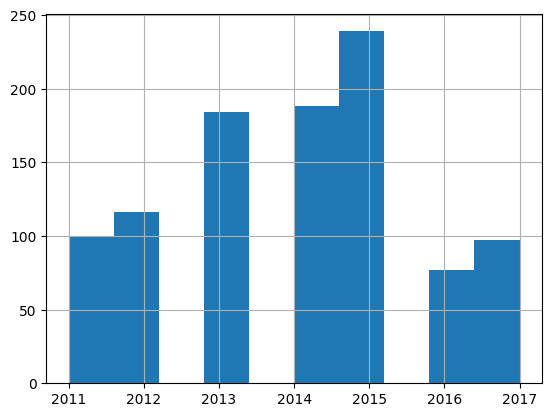

In [95]:
dataset['year_to_start'].hist()

In [96]:
dataset['year_to_start'].value_counts().nlargest(1)

,count
year_to_start,
2015,239


### f.	Сколько всего авто совершило меньше чем 10000 поездок?

In [97]:
dataset[dataset['riders'] < 10000].shape[0]

93

### g.	Какой класс авто, у которых рейтинг выше медианного значения является вторым по популярности в выборке?

In [98]:
dataset[dataset['car_rating'] > dataset['car_rating'].median()]['car_type'].value_counts().nlargest(2).iloc[[1]]

,count
car_type,
standart,134


### h.	Сколько поездок на авто премиум класса 2016 года выпуска с электрическим двигателем было совершено?

In [99]:
dataset[(dataset['car_type'] == 'premium') &
        (dataset['year_to_start'] == 2016) &
        (dataset['fuel_type'] == 'electro')]['riders'].sum()

476627

## Машинное обучение

### a.	Заполнить пропущенные значения в dataset

In [100]:
count_nans_in_features(dataset)

,Пропуски (NaN или NaT),Нули (0)
sample_id,0,0
model,0,0
car_type,0,0
fuel_type,1,0
car_rating,0,1
year_to_start,0,0
riders,0,0
year_to_work,0,0
date_to_break,2,0
target_class,0,0


Посмотрим распределение фичей, в которых есть пропуски и нули

<Axes: >

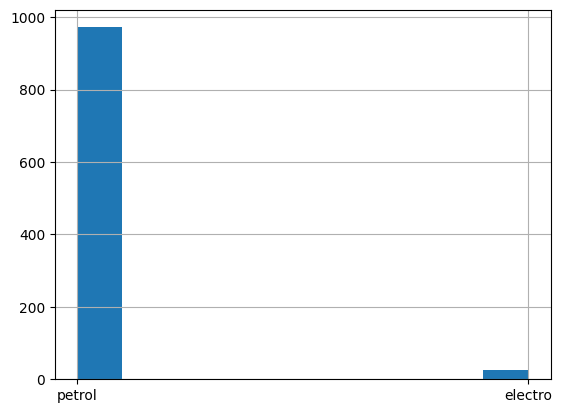

In [101]:
dataset['fuel_type'].hist()

<Axes: >

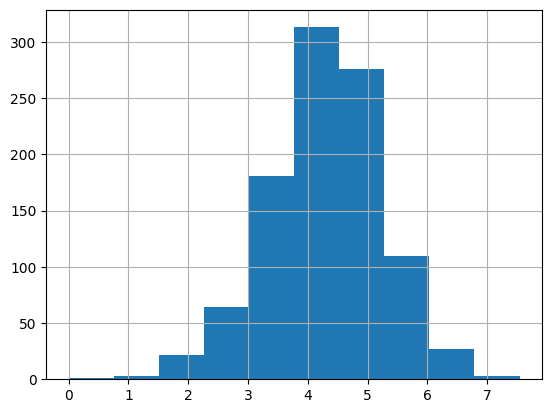

In [102]:
dataset['car_rating'].hist()

<Axes: >

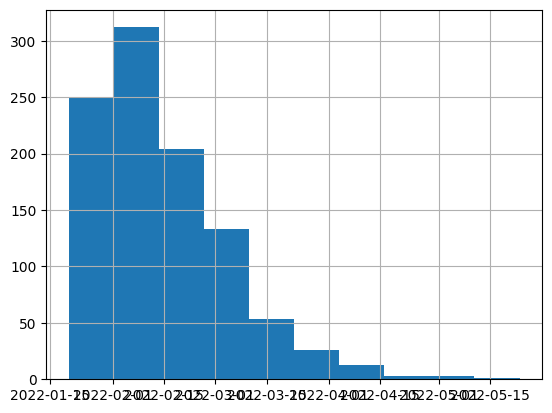

In [103]:
dataset['date_to_break'].hist()

Заменим недостающие данные

In [104]:
dataset['fuel_type'] = dataset.groupby('model')['fuel_type'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) # категориальныя переменная
)

dataset['car_rating'] = dataset.groupby('model')['car_rating'].transform(
    lambda x: x.replace(0, x.mean()) # числовая переменная
)

# Обработка date_to_break: заполняем NaN наиболее частой датой
dataset['date_to_break'] = dataset.groupby('model')['date_to_break'].transform(
    lambda x: x.fillna(x.mode().iloc[0]) # дата
)


In [105]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   sample_id      1000 non-null   object        
 1   model          1000 non-null   object        
 2   car_type       1000 non-null   object        
 3   fuel_type      1000 non-null   object        
 4   car_rating     1000 non-null   float64       
 5   year_to_start  1000 non-null   int64         
 6   riders         1000 non-null   int64         
 7   year_to_work   1000 non-null   int64         
 8   date_to_break  1000 non-null   datetime64[ns]
 9   target_class   1000 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 78.3+ KB


### b.	Разделить выборку на тестовую и тренировочную

In [106]:
dataset['target_class'].value_counts()

,count
target_class,
another_bug,121
engine_ignition,119
engine_overheat,116
electro_bug,113
break_bug,113
gear_stick,113
engine_fuel,112
engine_check,112
wheel_shake,81


In [107]:
y = dataset['target_class']
X = dataset.drop(columns=['target_class','sample_id'])

Задача многоклассовой классификации. Чтобы грамотно разбить такую выборку, важно, чтобы в тестовую выборку значения классов попали соразмерно их распределению в исходных данных

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### c.	На основе dataset решить задачу классификации

Признаки:
sample_id
car_id
model
car_type
fuel_type
car_rating
riders
year_to_start
year_to_work
date_to_break

Целевая переменная:
target_class


In [109]:
X_train.head(1)

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break
752,Mini Cooper,business,petrol,3.82,2015,80980,2021,2022-02-16


Для обучения данной модели требуется применить все имеющиеся признаки. Признак car_id отсутствует в исходных данных, возможно, опечатка

Признак sample_id является иднтификатором и у нас нет информации о смысле, который он может содержать. Полезно было бы извлечь из него информацию, но пока принято решение его удалить

Для решения задачи многоклассовой классификации применим модель CatBoostClassifier. Данная модель не требует one-hot преобразования для переменных и масштабирования данных перед применением

In [110]:
cat_features = ['model', 'car_type', 'fuel_type']

In [111]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 752 to 97
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   model          800 non-null    object        
 1   car_type       800 non-null    object        
 2   fuel_type      800 non-null    object        
 3   car_rating     800 non-null    float64       
 4   year_to_start  800 non-null    int64         
 5   riders         800 non-null    int64         
 6   year_to_work   800 non-null    int64         
 7   date_to_break  800 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 56.2+ KB


In [112]:
model = CatBoostClassifier(cat_features=cat_features, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

Learning rate set to 0.078231
0:	learn: 2.1468709	total: 132ms	remaining: 2m 11s
1:	learn: 2.1036461	total: 239ms	remaining: 1m 59s
2:	learn: 2.0553161	total: 359ms	remaining: 1m 59s
3:	learn: 2.0209743	total: 491ms	remaining: 2m 2s
4:	learn: 1.9908027	total: 603ms	remaining: 1m 59s
5:	learn: 1.9552343	total: 719ms	remaining: 1m 59s
6:	learn: 1.9226852	total: 792ms	remaining: 1m 52s
7:	learn: 1.8970598	total: 818ms	remaining: 1m 41s
8:	learn: 1.8661467	total: 944ms	remaining: 1m 43s
9:	learn: 1.8427083	total: 1.13s	remaining: 1m 51s
10:	learn: 1.8261613	total: 1.22s	remaining: 1m 49s
11:	learn: 1.8067603	total: 1.37s	remaining: 1m 53s
12:	learn: 1.7906182	total: 1.48s	remaining: 1m 52s
13:	learn: 1.7702877	total: 1.53s	remaining: 1m 47s
14:	learn: 1.7568580	total: 1.55s	remaining: 1m 41s
15:	learn: 1.7412702	total: 1.61s	remaining: 1m 38s
16:	learn: 1.7305916	total: 1.76s	remaining: 1m 41s
17:	learn: 1.7163943	total: 1.86s	remaining: 1m 41s
18:	learn: 1.7111025	total: 1.89s	remaining: 

KeyboardInterrupt: 

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

### d.	Вывести (напечатать) оценку работы метода

Проведем оценку качества, используя метрики для задачи классификации. Будем считать по макроусреднению

In [ ]:
# Тестовая выборка
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='macro')
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [ ]:
# Обучаюая выборка
accuracy = accuracy_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train, average='macro')
precision = precision_score(y_train, y_pred_train, average='macro')
recall = recall_score(y_train, y_pred_train, average='macro')

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Ожидаемо на обучающей выборке результат лучше

### e.	Нарисовать графики сравнения факта и прогноза

Построим confusion matrix для сравнения

In [ ]:
cm = confusion_matrix(y_test, y_pred_test)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset['target_class'].unique(),
            yticklabels=dataset['target_class'].unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

На текущем этапе можно сказать, что модель не очень хорошо предсказывает классы в тестовой выборке и довольно часто ошибается. Чтобы улучшить результат, может потребоваться больше данных в тестовой выборке либо дополнительная обработка данных и выделение новых признаков

In [ ]:
dataset_origin = dataset.copy()

### Улучшение результата модели

#### С этой ячейки код будет повторно запускаться при тестировании гипотез

In [113]:
dataset = dataset_origin.copy()

#### Гипотеза 1: Добавление нормализации



Модель Кэтбуст умеет самостоятельно обрабатывать признаки без нормализации, но это может дать определенный результата

In [114]:
# from sklearn.preprocessing import StandardScaler

# numeric_cols = dataset.select_dtypes(include=['int64', 'float64']).columns
# scaler = StandardScaler()
# dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])

Результат модели не изменился

#### Гипотеза 2: Преобразование дат

In [115]:
dataset.head(1)

,sample_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,date_to_break,target_class
0,559c6886,Skoda Rapid,economy,petrol,4.8,2013,42269,2019,2022-01-31,engine_overheat


Преобразуем имеющуюся сейчас дату date_to_break к трем новым признакам: день поломки, месяц поломки, год поломки

In [116]:
dataset['break_day'] = dataset['date_to_break'].dt.day
dataset['break_month'] = dataset['date_to_break'].dt.month
dataset['break_year'] = dataset['date_to_break'].dt.year
dataset.drop(columns=['date_to_break'], inplace=True)

Accuracy: 0.32 - немного улучшили результат модели

#### Гипотеза 3: Добавление разницы времен

Добавим 3 новых признака:

Время эксплуатация: Год поломки - год начала работы в автопарке

Время существования: Год поломки - год выпуска машины

Время простоя: год начала работы - год выпуска

In [117]:
dataset['existing'] = dataset['break_year'] - dataset['year_to_start']
dataset['operating'] = dataset['break_year'] - dataset['year_to_work']
dataset['downtime'] = dataset['year_to_work'] - dataset['year_to_start']
# 3 признака acc 0,31
# 2 признака acc 0,31
# 1 признак acc 0,315

In [118]:
dataset['use_intensity'] = dataset['riders']/(dataset['break_year'] - dataset['year_to_start']) # acc 0,3

Данные признаки не улучшили результат модели

#### Гипотеза 4: Сезонность

Добавим время года, день недели, выходные

In [119]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [123]:
dataset['break_season'] = dataset['break_month'].apply(get_season)

Результат никак не изменился

#### Гипотеза 5: Статистическая агрегация

In [121]:
# Количество поломок по модели
model_break_type_counts = dataset.groupby(['model', 'target_class']).size().unstack(fill_value=0)
model_break_type_counts.columns = [f'model_break_{col}_count' for col in model_break_type_counts.columns]
model_break_type_counts = model_break_type_counts.reset_index()


dataset = dataset.merge(model_break_type_counts, on='model', how='left')



In [124]:
# Количество поломок по типу топлива
model_break_type_counts = dataset.groupby(['fuel_type', 'target_class']).size().unstack(fill_value=0)
model_break_type_counts.columns = [f'fuel_break_{col}_count' for col in model_break_type_counts.columns]
model_break_type_counts = model_break_type_counts.reset_index()


dataset = dataset.merge(model_break_type_counts, on='fuel_type', how='left')

In [126]:
# Количество поломок по классу
model_break_type_counts = dataset.groupby(['car_type', 'target_class']).size().unstack(fill_value=0)
model_break_type_counts.columns = [f'type_break_{col}_count' for col in model_break_type_counts.columns]
model_break_type_counts = model_break_type_counts.reset_index()


dataset = dataset.merge(model_break_type_counts, on='car_type', how='left')

In [129]:
# Количество поломок по сезонам
model_break_type_counts = dataset.groupby(['break_season', 'target_class']).size().unstack(fill_value=0)
model_break_type_counts.columns = [f'season_break_{col}_count' for col in model_break_type_counts.columns]
model_break_type_counts = model_break_type_counts.reset_index()


dataset = dataset.merge(model_break_type_counts, on='break_season', how='left')

Acc = 0.31

In [130]:
# Средний рейтинг по модели
model_avg_rating = dataset.groupby('model')['car_rating'].mean().reset_index()
model_avg_rating.columns = ['model', 'model_avg_rating']
dataset = dataset.merge(model_avg_rating, on='model', how='left')
#acc=0.29

In [132]:
# Группировки для статистик
model_stats = dataset.groupby('model').agg({
    'car_rating': 'mean',
    'riders': ['mean', 'median']
}).reset_index()
model_stats.columns = ['model', 'model_avg_rating', 'model_avg_riders', 'model_median_riders']

# Статистика поломок по модели
model_break_stats = dataset.groupby('model')['target_class'].agg([
    ('total_breaks', 'count'),
    ('unique_break_types', lambda x: x.nunique())
]).reset_index()

# Доля каждого типа поломки
break_type_ratio = dataset.groupby(['model', 'target_class']).size().unstack(fill_value=0)
break_type_ratio = break_type_ratio.div(break_type_ratio.sum(axis=1), axis=0)
break_type_ratio.columns = [f'break_type_ratio_{col}' for col in break_type_ratio.columns]
break_type_ratio = break_type_ratio.reset_index()

# Объединение признаков
dataset = dataset.merge(model_stats, on='model', how='left')
dataset = dataset.merge(model_break_stats, on='model', how='left')
dataset = dataset.merge(break_type_ratio, on='model', how='left')

#### Гипотеза 6: Изменение весов модели

In [131]:
def calculate_class_weights(y_true):
    """
    Расчет весов классов обратно пропорционально их частоте

    Parameters:
    y_true (array-like): Истинные метки классов

    Returns:
    dict: Словарь весов для каждого класса
    """
    # Подсчет частоты каждого класса
    class_counts = pd.Series(y_true).value_counts()

    # Обратное взвешивание с нормализацией
    total_samples = len(y_true)
    class_weights = {
        cls: total_samples / (len(class_counts) * count)
        for cls, count in class_counts.items()
    }

    return class_weights

#### Обучение модели на новых данных

In [133]:
y = dataset['target_class']
X = dataset.drop(columns=['target_class','sample_id',])

In [134]:
class_weights = calculate_class_weights(y)

In [135]:
X.head(1)

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,break_day,break_month,break_year,...,unique_break_types,break_type_ratio_another_bug,break_type_ratio_break_bug,break_type_ratio_electro_bug,break_type_ratio_engine_check,break_type_ratio_engine_fuel,break_type_ratio_engine_ignition,break_type_ratio_engine_overheat,break_type_ratio_gear_stick,break_type_ratio_wheel_shake
0,Skoda Rapid,economy,petrol,4.8,2013,42269,2019,31,1,2022,...,9,0.09375,0.15625,0.125,0.140625,0.09375,0.09375,0.0625,0.078125,0.15625


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [137]:
cat_features = ['model', 'car_type', 'fuel_type','break_season']

In [138]:
model = CatBoostClassifier(cat_features=cat_features, loss_function='MultiClass', verbose=False, class_weights=class_weights)
model.fit(X_train, y_train)

In [139]:
y_pred_test = model.predict(X_test)

#### Анализ важности признаков

Text(0.5, 1.0, 'Feature Importance')

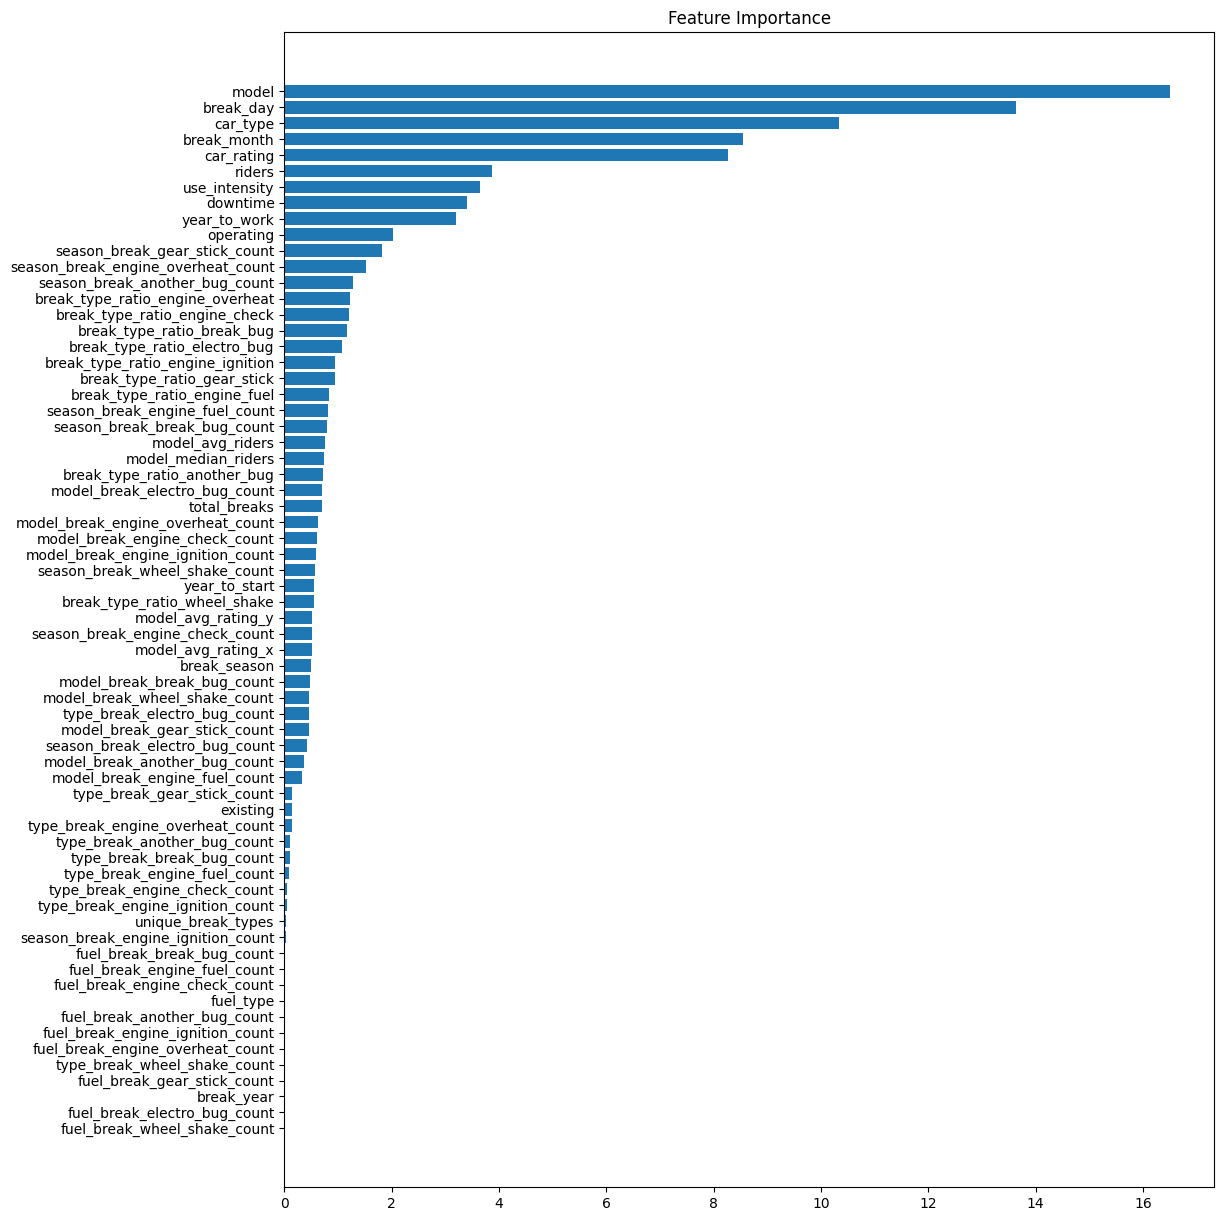

In [140]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

#### Результат

In [141]:
accuracy = accuracy_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test, average='macro')
precision = precision_score(y_test, y_pred_test, average='macro')
recall = recall_score(y_test, y_pred_test, average='macro')

# Выводим результаты
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.315
F1 Score: 0.29699820897030876
Precision: 0.2952130986227096
Recall: 0.306873078612209


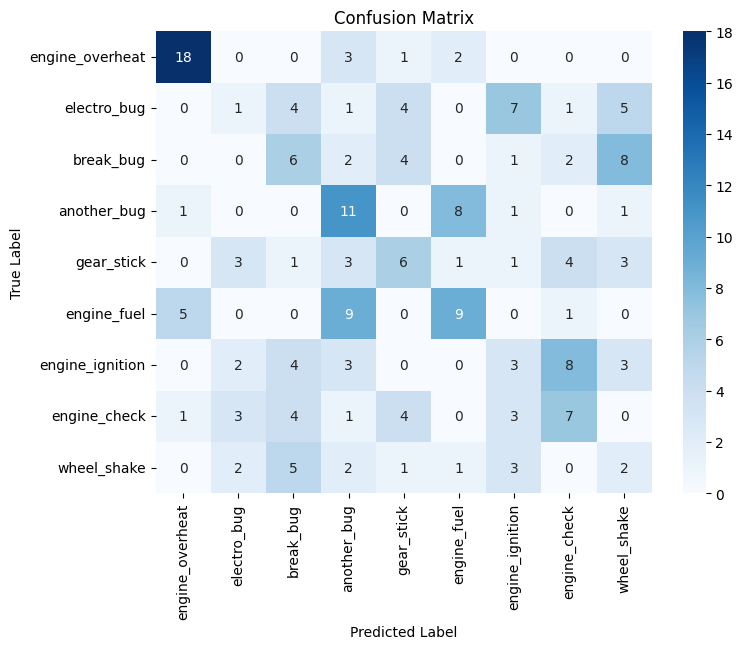

In [142]:
cm = confusion_matrix(y_test, y_pred_test)

# Визуализируем матрицу ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset['target_class'].unique(),
            yticklabels=dataset['target_class'].unique())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()